Este notebook contiene el código desarrollado para el Trabajo de Fin de Máster del alumno Francisco Blas Martínez Pareja, en el máster en Ciberseguridad por la Universidad de Cádiz 

En este cuaderno se desarrolla y analiza una propuesta de mejora del algoritmo **SMOTE (Synthetic Minority Over-sampling Technique)**, una de las técnicas más utilizadas para el tratamiento del desbalanceo de clases en problemas de clasificación.

El objetivo principal es **generar instancias sintéticas de la clase minoritaria** teniendo en cuenta la **correlación entre variables**. Mientras que el SMOTE tradicional interpola valores de manera uniforme entre instancias vecinas, la variante propuesta incorpora métricas de **correlación** y **Mutual Information** para guiar el proceso de generación de nuevas muestras. De esta forma, se pretende crear ejemplos más representativos y realistas, mejorando el rendimiento de los clasificadores en escenarios de datos desbalanceados.

**IMPORTANTE**: Para optimizar parámetros y evaluar los modelos, el notebook guarda los resultados en la carpeta "Resultados" en archivos .csv. Si estos archivos ya existen, el notebook los cargará en lugar de recalcularlos, evitando así procesos largos. Si se desea volver a calcular los resultados, es necesario vaciar la carpeta "Resultados" antes de ejecutar el notebook.

# Importación de librerias

En primer lugar importamos las librerías necesarias para el proyecto. Las que más usaremos serán **pandas** para tratar los conjuntos de datos, **sklearn** para entrenar modelos y **imblearn**, que implementa SMOTE y sus variantes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder,StandardScaler

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

from src.custom_smote import CustomSMOTE
from src.experiments import tune_sampler_for_dataset, optimize_models_parameters, evaluate_models
from src.utils import csv_to_dict, TabTransformerClassifier, measure_default_times

# Cargar Conjuntos de Datos

Una vez importadas las librerías, vamos a cargar todos los conjuntos de datos que utilizaremos en este proyecto para validar la nueva propuesta de la variante de SMOTE.

In [2]:
cic_ids2017 = pd.read_csv('./Datasets/cic_ids2017.csv')
unsw = pd.read_csv('./Datasets/UNSW-NB15.csv', header=None) # header None para los que vienen sin nombres de columna
credit = pd.read_csv('./Datasets/creditcard.csv')
litnet = pd.read_csv('./Datasets/litnet.csv', header=None)
ugr = pd.read_csv('./Datasets/ugr16.csv', header=None)

C:\Users\fblas\AppData\Local\Temp\ipykernel_12392\375191150.py:2: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  unsw = pd.read_csv('./Datasets/UNSW-NB15.csv', header=None) # header None para los que vienen sin nombres de columna


Vamos a ver la estructura incial de los conjuntos de datos que hemos cargado.

In [3]:
cic_ids2017

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,55641,49,1,3,6,18,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,45337,217,2,1,31,6,31,0,15.500000,21.920310,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,22,1387547,41,46,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,22,207,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
counts = cic_ids2017["Label"].value_counts()
percents = cic_ids2017["Label"].value_counts(normalize=True) * 100

for clase, count in counts.items():
    print(f"Clase {clase}: {count} instancias ({percents[clase]:.2f}%)")


Clase BENIGN: 2273097 instancias (80.30%)
Clase DoS Hulk: 231073 instancias (8.16%)
Clase PortScan: 158930 instancias (5.61%)
Clase DDoS: 128027 instancias (4.52%)
Clase DoS GoldenEye: 10293 instancias (0.36%)
Clase FTP-Patator: 7938 instancias (0.28%)
Clase SSH-Patator: 5897 instancias (0.21%)
Clase DoS slowloris: 5796 instancias (0.20%)
Clase DoS Slowhttptest: 5499 instancias (0.19%)
Clase Bot: 1966 instancias (0.07%)
Clase Web Attack � Brute Force: 1507 instancias (0.05%)
Clase Web Attack � XSS: 652 instancias (0.02%)
Clase Infiltration: 36 instancias (0.00%)
Clase Web Attack � Sql Injection: 21 instancias (0.00%)
Clase Heartbleed: 11 instancias (0.00%)


In [5]:
unsw

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699996,59.166.0.8,12520,149.171.126.6,31010,tcp,FIN,0.020383,320,1874,31,...,0,8,20,7,5,1,1,4,NaN,0
699997,59.166.0.0,18895,149.171.126.9,80,tcp,FIN,1.402957,19410,1087890,31,...,0,1,1,2,7,2,2,2,NaN,0
699998,59.166.0.0,30103,149.171.126.5,5190,tcp,FIN,0.007108,2158,2464,31,...,0,13,13,6,7,2,1,2,NaN,0
699999,59.166.0.6,30388,149.171.126.5,111,udp,CON,0.004435,568,304,31,...,0,10,13,6,5,1,1,3,NaN,0


In [6]:
counts = unsw[48].value_counts()
percents = unsw[48].value_counts(normalize=True) * 100

for clase, count in counts.items():
    print(f"Clase {clase}: {count} instancias ({percents[clase]:.2f}%)")

Clase 0: 677786 instancias (96.83%)
Clase 1: 22215 instancias (3.17%)


In [7]:
credit

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [8]:
counts = credit["Class"].value_counts()
percents = credit["Class"].value_counts(normalize=True) * 100

for clase, count in counts.items():
    print(f"Clase {clase}: {count} instancias ({percents[clase]:.2f}%)")

Clase 0: 284315 instancias (99.83%)
Clase 1: 492 instancias (0.17%)


In [9]:
litnet

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,1,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
1,2,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
2,3,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
3,4,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4,5,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407197,4407198,2020,1,31,15,39,53,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4407198,4407199,2020,1,31,15,39,53,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4407199,4407200,2020,1,31,15,39,53,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4407200,4407201,2020,1,31,15,39,53,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0


In [10]:
counts = litnet[83].value_counts()
percents = litnet[83].value_counts(normalize=True) * 100

for clase, count in counts.items():
    print(f"Clase {clase}: {count} instancias ({percents[clase]:.2f}%)")

Clase none: 4336095 instancias (98.39%)
Clase icmp_smf: 59479 instancias (1.35%)
Clase icmp_f: 11628 instancias (0.26%)


In [11]:
ugr

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2016-03-18 10:52:40,0.0,127.204.60.89,42.219.153.89,123,425,UDP,.A....,0,0,1,76,background
1,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.154.108,53,41294,UDP,.A....,0,0,1,140,background
2,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.154.108,53,46784,UDP,.A....,0,0,1,141,background
3,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.158.161,53,35972,UDP,.A....,0,0,1,113,background
4,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.158.164,53,41853,UDP,.A....,0,0,1,103,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2016-03-18 10:56:19,0.0,201.112.211.211,42.219.156.211,57593,443,TCP,.APR..,0,0,2,135,background
199996,2016-03-18 10:56:19,0.0,201.174.68.132,42.219.159.197,0,0,ICMP,.A....,0,0,1,32,background
199997,2016-03-18 10:56:19,0.0,202.215.122.94,42.219.152.249,64976,53,UDP,.A....,0,40,1,71,background
199998,2016-03-18 10:56:19,0.0,203.115.96.255,42.219.153.191,3063,53,UDP,.A....,0,40,1,67,background


In [12]:
counts = ugr[12].value_counts()
percents = ugr[12].value_counts(normalize=True) * 100

for clase, count in counts.items():
    print(f"Clase {clase}: {count} instancias ({percents[clase]:.2f}%)")

Clase background: 199301 instancias (99.65%)
Clase blacklist: 699 instancias (0.35%)


Como se puede observar, los conjuntos de datos tienen estrucuras y tamaños muy variados, con algunas columnas categóricas y otras cuantitativas. Además, todos presentan desbalance de clases, algunos moderado y otros extremo.

# Preprocesamiento de datos

Para poder realizar el entrenamiento de modelos es preciso realizar un procesamiento de los datos primero, ya que muchos modelos sólo trabajan con datos numéricos y no son capaces de procesar columnas categóricas. Por eso, en esta primera fase vamos a realizar un procesado de datos para dejar a los datasets en perfectas condiciones para poder entrenar los modelos.

Ponemos los nombres de las columnas a los datasets que no las tenían.

In [13]:
unsw.columns = [
    "srcip", "sport", "dstip", "dsport", "proto", "state", "dur",
    "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "service",
    "Sload", "Dload", "Spkts", "Dpkts", "swin", "dwin", "stcpb", "dtcpb",
    "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit",
    "Stime", "Ltime", "Sintpkt", "Dintpkt", "tcprtt", "synack", "ackdat",
    "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login",
    "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
    "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm",
    "attack_cat", "Label"
]

unsw

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699996,59.166.0.8,12520,149.171.126.6,31010,tcp,FIN,0.020383,320,1874,31,...,0,8,20,7,5,1,1,4,NaN,0
699997,59.166.0.0,18895,149.171.126.9,80,tcp,FIN,1.402957,19410,1087890,31,...,0,1,1,2,7,2,2,2,NaN,0
699998,59.166.0.0,30103,149.171.126.5,5190,tcp,FIN,0.007108,2158,2464,31,...,0,13,13,6,7,2,1,2,NaN,0
699999,59.166.0.6,30388,149.171.126.5,111,udp,CON,0.004435,568,304,31,...,0,10,13,6,5,1,1,3,NaN,0


In [14]:
litnet.columns = ["ID","ts_year","ts_month","ts_day","ts_hour","ts_min","ts_second","te_year","te_month",
          "te_day","te_hour","te_min","te_second","time_delta","src_add","dest_add","src_port","dest_port",
          "proto","_flag1","_flag2","_flag3","_flag4","_flag5","_flag6","fwd_status","in_tos_field","in_pkt","in_bytes",
          "out_pkt","out_bytes","in_bytes_per_flow","out_bytes_per_flow","src_as","dest_as","src_mask","dest_mask",
          "out_tos_field","flow_dir","next_hop","next_hop_bgp","src_vlan","dest_vlan","in_src_mac","out_dest_mac","in_dest_mac","out_src_mac",
          "mpls1","mpls2","mpls3","mpls4","mpls5","mpls6","mpls7","mpls8","mpls9","mpls10","class_id","selector_id",
          "sampl_alg","ra","engine","exporting_proc_id","tr","icmp_flood_brdcast","icmp_flood_ip","udp_ddos","tcp_flood_syn","tcp_f_n_a",
          "tcp_f_n_f","tcp_f_n_r","tcp_f_n_p","tcp_f_n_u","http_ddos","tcp_land_syn","tftp_flood",
          "kerberos_flood","rpc_flood","http_vulnerabilities","smtp_flood","udp_port_range","port_range",
          "udp_ddos_fragmented","attack_type","attack_action"]

litnet

,ID,ts_year,ts_month,ts_day,ts_hour,ts_min,ts_second,te_year,te_month,te_day,...,tftp_flood,kerberos_flood,rpc_flood,http_vulnerabilities,smtp_flood,udp_port_range,port_range,udp_ddos_fragmented,attack_type,attack_action
0,1,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
1,2,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
2,3,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
3,4,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4,5,2020,1,31,15,34,58,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407197,4407198,2020,1,31,15,39,53,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4407198,4407199,2020,1,31,15,39,53,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4407199,4407200,2020,1,31,15,39,53,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4407200,4407201,2020,1,31,15,39,53,2020,1,31,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0


In [15]:
ugr.columns = ["timestamp","duration","srcip","dstip","sport","dport","protocol","flags","pkt_count_fwd","pkt_count_rev",
               "byte_count_fwd","byte_count_rev","class"]

ugr

,timestamp,duration,srcip,dstip,sport,dport,protocol,flags,pkt_count_fwd,pkt_count_rev,byte_count_fwd,byte_count_rev,class
0,2016-03-18 10:52:40,0.0,127.204.60.89,42.219.153.89,123,425,UDP,.A....,0,0,1,76,background
1,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.154.108,53,41294,UDP,.A....,0,0,1,140,background
2,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.154.108,53,46784,UDP,.A....,0,0,1,141,background
3,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.158.161,53,35972,UDP,.A....,0,0,1,113,background
4,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.158.164,53,41853,UDP,.A....,0,0,1,103,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2016-03-18 10:56:19,0.0,201.112.211.211,42.219.156.211,57593,443,TCP,.APR..,0,0,2,135,background
199996,2016-03-18 10:56:19,0.0,201.174.68.132,42.219.159.197,0,0,ICMP,.A....,0,0,1,32,background
199997,2016-03-18 10:56:19,0.0,202.215.122.94,42.219.152.249,64976,53,UDP,.A....,0,40,1,71,background
199998,2016-03-18 10:56:19,0.0,203.115.96.255,42.219.153.191,3063,53,UDP,.A....,0,40,1,67,background


## Columnas constantes

Estudiamos las columnas constantes (mismo valor para todas las filas) de los datasets y las eliminamos, pues estas no aportan ningún tipo de información relevante para los modelos de entrenamiento, ya que no permiten extraer ningún tipo de patrón.

In [16]:
datasets = {
    'CIC_IDS2017': cic_ids2017,
    'UNSW': unsw,
    'CREDIT': credit,
    'LITNET': litnet,
    'UGR16' : ugr
}

In [17]:
# Buscar columnas constantes en cada dataset
for name, df in datasets.items():
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    print(f"Columnas con un solo valor en todas las filas en el dataset {name}:")
    print(constant_cols if constant_cols else "✅ Ninguna")
    print('\n' + '-'*50 + '\n')

Columnas con un solo valor en todas las filas en el dataset CIC_IDS2017:
['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

--------------------------------------------------

Columnas con un solo valor en todas las filas en el dataset UNSW:
✅ Ninguna

--------------------------------------------------

Columnas con un solo valor en todas las filas en el dataset CREDIT:
✅ Ninguna

--------------------------------------------------

Columnas con un solo valor en todas las filas en el dataset LITNET:
['ts_year', 'ts_month', 'ts_day', 'ts_hour', 'te_year', 'te_month', 'te_day', 'te_hour', '_flag1', 'fwd_status', 'out_pkt', 'out_bytes', 'src_mask', 'dest_mask', 'out_tos_field', 'flow_dir', 'next_hop', 'next_hop_bgp', 'src_vlan', 'dest_vlan', 'in_src_mac', 'out_dest_mac', 'in_dest_mac', 'out_src_mac', 'mpls1', 'mpls2', 'mpls3', 'mpls4', 'mpls5', 'mpls6', 'mpls7', 'mpls8', '

In [18]:
# Eliminacion columnas constantes
cic_ids2017.drop(columns=['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 
                          'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'], inplace=True)

litnet.drop(columns=['ID','ts_year','ts_month','ts_day','ts_hour','ts_min','ts_second','te_year','te_month','te_day','te_hour',
                     'te_min','te_second','fwd_status', 'out_pkt', 'out_bytes', 'src_mask', 'dest_mask', 'out_tos_field', 
                     'flow_dir', 'next_hop', 'next_hop_bgp', 'src_vlan', 'dest_vlan', 'in_src_mac', 'out_dest_mac', 'in_dest_mac', 
                     'out_src_mac', 'mpls1', 'mpls2', 'mpls3', 'mpls4', 'mpls5', 'mpls6', 'mpls7', 'mpls8', 'mpls9', 'mpls10', 
                     'class_id', 'selector_id', 'sampl_alg', 'ra', 'engine', 'tr'], inplace=True)

ugr.drop(columns=['pkt_count_fwd'], inplace=True)

## Valores Nulos

Algunos datasets contienen valores faltantes en algunas de sus columnas. Estos valores también son un problema para los modelos y deben ser tratados. Por lo general, se pueden eliminar instancias con algún valor nulo si estas no representan una gran cantidad con respecto al número total de instancias del conjunto de datos. También, si alguna columna tiene casi todos sus valores nulos, puede ser eliminada ya que no aportará información relevante.

In [19]:
# Ver que datasets tienen valores nulos
for name, df in datasets.items():
    nulls = df.isnull().sum()
    nulls_with_values = nulls[nulls > 0]

    if not nulls_with_values.empty:
        print(f"⚠️  El dataset '{name}' tiene valores nulos en las siguientes columnas:")
        print(nulls_with_values)
    else:
        print(f"✅ El dataset '{name}' NO tiene valores nulos.")

    print('\n' + '-'*50 + '\n')


⚠️  El dataset 'CIC_IDS2017' tiene valores nulos en las siguientes columnas:
Flow Bytes/s    1358
dtype: int64

--------------------------------------------------

⚠️  El dataset 'UNSW' tiene valores nulos en las siguientes columnas:
attack_cat    677786
dtype: int64

--------------------------------------------------

✅ El dataset 'CREDIT' NO tiene valores nulos.

--------------------------------------------------

✅ El dataset 'LITNET' NO tiene valores nulos.

--------------------------------------------------

✅ El dataset 'UGR16' NO tiene valores nulos.

--------------------------------------------------



In [20]:
# Eliminar valores nulos en CIC_IDS2017 ya que hay muy pocos con respecto al total de instancias
cic_ids2017.dropna(inplace=True)

# Eliminamos columna 'attack_cat' en UNSW ya que 67000 de los 70000 valores son nulos
unsw.drop(columns=['attack_cat'], inplace=True)

## Columnas no Numéricas

Los modelos de entrenamiento solo tratan con variables numéricas. Por tanto, todas las columnas que no sean numéricas deben ser transformadas de manera que se conviertan en columnas numéricas.

In [21]:
# Ver qué columnas no son numéricas para cada dataset
for name, df in datasets.items():
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns

    if len(non_numeric_cols) > 0:
        print(f"ℹ️  El dataset '{name}' tiene las siguientes columnas no numéricas:")
        for col in non_numeric_cols:
            print(f" - {col}")
    else:
        print(f"✅ El dataset '{name}' NO tiene columnas no numéricas.")

    print('\n' + '-'*50 + '\n')


ℹ️  El dataset 'CIC_IDS2017' tiene las siguientes columnas no numéricas:
 - Label

--------------------------------------------------

ℹ️  El dataset 'UNSW' tiene las siguientes columnas no numéricas:
 - srcip
 - sport
 - dstip
 - dsport
 - proto
 - state
 - service

--------------------------------------------------

✅ El dataset 'CREDIT' NO tiene columnas no numéricas.

--------------------------------------------------

ℹ️  El dataset 'LITNET' tiene las siguientes columnas no numéricas:
 - src_add
 - dest_add
 - proto
 - _flag1
 - _flag2
 - _flag3
 - _flag4
 - _flag5
 - _flag6
 - icmp_flood_brdcast
 - icmp_flood_ip
 - udp_ddos
 - tcp_flood_syn
 - tcp_f_n_a
 - tcp_f_n_f
 - tcp_f_n_r
 - tcp_f_n_p
 - tcp_f_n_u
 - http_ddos
 - tcp_land_syn
 - tftp_flood
 - kerberos_flood
 - rpc_flood
 - http_vulnerabilities
 - smtp_flood
 - udp_port_range
 - port_range
 - udp_ddos_fragmented
 - attack_type

--------------------------------------------------

ℹ️  El dataset 'UGR16' tiene las siguientes c

Vamos a ir tratando las columna no numéricas de forma individual para cada conjunto de datos.

***Dataset CIC_IDS2017***

La única columna no numérica es la de la clase a predecir. Vamos a convertir el problema en un problema de clasificación binaria, agrupando los distintos tipos de ataques y distinguiendo simplemente entre tráfico maligno (1) y benigno (0).

In [22]:
# Convertir en un problema de clasificación binaria
cic_ids2017['Label'] = cic_ids2017['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

***Dataset UNSW***

Vamos a ver qué valores toman las diferentes columnas no numéricas para poder decidir cómo tratarlas.

In [23]:
print(unsw['srcip'].value_counts())
print(unsw['dstip'].value_counts())

srcip
59.166.0.2         67209
59.166.0.0         67128
59.166.0.5         67091
59.166.0.4         66722
59.166.0.1         66587
59.166.0.3         66145
59.166.0.6         64689
59.166.0.8         64640
59.166.0.9         64187
59.166.0.7         63725
175.45.176.1       14325
149.171.126.18      6010
175.45.176.3        5128
175.45.176.0        4782
175.45.176.2        3236
10.40.85.1          1680
10.40.182.1         1670
10.40.85.30          888
10.40.170.2          874
10.40.182.3          874
149.171.126.1        251
149.171.126.5        249
149.171.126.6        241
149.171.126.2        232
149.171.126.3        231
149.171.126.4        225
149.171.126.9        217
149.171.126.8        217
149.171.126.7        207
149.171.126.0        192
192.168.241.243      108
149.171.126.11        16
149.171.126.15         8
149.171.126.16         6
149.171.126.19         3
149.171.126.10         3
149.171.126.12         2
149.171.126.13         1
149.171.126.17         1
127.0.0.1          

In [24]:
print(unsw['sport'].value_counts())
print(unsw['dsport'].value_counts())

sport
0        6056
47439    4689
1043     4033
0        3612
47439    2243
         ... 
14415       1
16082       1
5163        1
42688       1
34143       1
Name: count, Length: 100270, dtype: int64
dsport
53       107485
80        61279
5190      33429
53        29812
6881      28222
          ...  
7398          1
2168          1
56996         1
4321          1
59241         1
Name: count, Length: 87819, dtype: int64


In [25]:
print(unsw['proto'].value_counts())
print(unsw['state'].value_counts())
print(unsw['service'].value_counts())

proto
tcp     494737
udp     195479
arp       4062
ospf      2116
unas      1442
         ...  
xtp         14
3pc         14
udt          4
esp          2
rtp          1
Name: count, Length: 135, dtype: int64
state
FIN    487911
CON    187505
INT     21799
REQ      2429
CLO       111
URH       108
RST        74
ECO        26
ACC        22
PAR         4
TXD         2
URN         2
no          2
MAS         2
TST         2
ECR         2
Name: count, dtype: int64
service
-           430656
dns         121170
http         55858
ftp-data     37305
smtp         23588
ftp          16531
ssh          14636
pop3           206
ssl             20
snmp            14
radius           7
dhcp             7
irc              3
Name: count, dtype: int64


Además vamos a ver la correlación de cada una de estas columnas con la variable de salida.

In [26]:
X_cat = unsw[['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service']].copy()

# Forzamos todos los valores a tipo string
X_cat = X_cat.astype(str)

# Codificamos columna por columna
for col in X_cat.columns:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col])
    
mi = mutual_info_classif(X_cat, unsw['Label'], discrete_features=True)

for col, score in zip(X_cat.columns, mi):
    print(f"Mutual info entre {col} y Label: {score:.4f}")

Mutual info entre srcip y Label: 0.1238
Mutual info entre sport y Label: 0.0684
Mutual info entre dstip y Label: 0.1246
Mutual info entre dsport y Label: 0.0461
Mutual info entre proto y Label: 0.0202
Mutual info entre state y Label: 0.0504
Mutual info entre service y Label: 0.0046


En base a los resultados obtenidos, haremos lo siguiente con cada columna:

- ***Srcip***: Tiene altísima cardinalidad (muchos valores únicos), pero con una distribución muy concentrada en pocos valores. Solución: Agrupar por rango de IPs (por ejemplo, los 2 primeros octetos).
- ***Dstip***: Igual que Srcip.
- ***Sport***: También tiene una alta cardinalidad, y además aporta poca información a la variable de salida (Mutual Information 0.06). Podemos agrupar los puertos menos conocidos (mayor que 1024) y dejar los puertos más comunes.
- ***Dsport***: Igual que sport.
- ***Proto***: Alta cardinalidad y aporta muy poca información, la eliminaremos.
- ***State***: Sólo 16 valores únicos, lo cual no es mucho. Podemos conservar los estados más frecuentes y agrupar los otros como 'Other'.
- ***Service***: Aporta muy poca información y además la mayoría de valores son nulos, por lo que la eliminamos.

In [27]:
# Agrupar las ips por los dos primeros octetos
unsw['srcip'] = unsw['srcip'].apply(lambda x: '.'.join(x.split('.')[:2]))
unsw['dstip'] = unsw['dstip'].apply(lambda x: '.'.join(x.split('.')[:2]))

# Agrupar los puertos
def group_port(port):
    try:
        port = int(port)
        return port if port < 1024 else 'other'
    except:
        return 'other'

unsw['sport'] = unsw['sport'].apply(group_port)
unsw['dsport'] = unsw['dsport'].apply(group_port)

# Agrupar estados
top_states = ['FIN', 'CON', 'INT', 'REQ']
unsw['state'] = unsw['state'].apply(lambda x: x if x in top_states else 'other')

# Eliminar columnas que no aportan mucha información
unsw = unsw.drop(columns=['service','proto'])

Veamos como quedan ahora las columnas.

In [28]:
print(unsw['srcip'].value_counts())
print(unsw['sport'].value_counts())
print(unsw['dstip'].value_counts())
print(unsw['dsport'].value_counts())
print(unsw['state'].value_counts())


srcip
59.166     658123
175.45      27471
149.171      8312
10.40        5986
192.168       108
127.0           1
Name: count, dtype: int64
sport
other    689324
0          9668
80          285
53          156
25          115
143         108
111          81
21           79
22           59
259          54
137          19
500          16
68            8
800           5
123           2
761           2
256           2
768           2
445           1
225           1
840           1
281           1
779           1
231           1
851           1
309           1
862           1
908           1
464           1
179           1
316           1
510           1
867           1
67            1
Name: count, dtype: int64
dstip
149.171    685579
175.45       6055
10.40        4068
59.166       2262
224.0        1926
192.168       108
32.50           2
127.0           1
Name: count, dtype: int64
dsport
other    358505
53       137297
80        74627
25        30292
111       28946
          ...  
705  

Vemos que ya hemos reducido mucho la cardinalidad de las columnas no numéricas. Ahora aplicaremos *One-Hot Encoding* a las columnas de forma que se creará una nueva columna para cada valor distinto de las variables.

In [29]:
unsw = pd.get_dummies(unsw, columns=['srcip','sport','dstip','dsport','state'])

In [30]:
unsw

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,...,dsport_1012,dsport_1013,dsport_1014,dsport_1015,dsport_other,state_CON,state_FIN,state_INT,state_REQ,state_other
0,0.001055,132,164,31,29,0,0,5.004739e+05,6.218009e+05,2,...,False,False,False,False,False,True,False,False,False,False
1,0.036133,528,304,31,29,0,0,8.767609e+04,5.048017e+04,4,...,False,False,False,False,True,True,False,False,False,False
2,0.001119,146,178,31,29,0,0,5.218945e+05,6.362824e+05,2,...,False,False,False,False,False,True,False,False,False,False
3,0.001209,132,164,31,29,0,0,4.367246e+05,5.425972e+05,2,...,False,False,False,False,False,True,False,False,False,False
4,0.001169,146,178,31,29,0,0,4.995722e+05,6.090676e+05,2,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699996,0.020383,320,1874,31,29,1,2,1.047932e+05,6.436736e+05,6,...,False,False,False,False,True,False,True,False,False,False
699997,1.402957,19410,1087890,31,29,2,370,1.103783e+05,6.195098e+06,364,...,False,False,False,False,False,False,True,False,False,False
699998,0.007108,2158,2464,31,29,6,6,2.328644e+06,2.658413e+06,24,...,False,False,False,False,True,False,True,False,False,False
699999,0.004435,568,304,31,29,0,0,7.684329e+05,4.112740e+05,4,...,False,False,False,False,False,True,False,False,False,False


Como vemos hemos procesado todas las columnas no numéricas de forma que se han convertido en números o valores booleanos, lo cual es perfecto para los modelos.

### Dataset LitNet

In [31]:
litnet

,time_delta,src_add,dest_add,src_port,dest_port,proto,_flag1,_flag2,_flag3,_flag4,...,tftp_flood,kerberos_flood,rpc_flood,http_vulnerabilities,smtp_flood,udp_port_range,port_range,udp_ddos_fragmented,attack_type,attack_action
0,0.000,74.82.47.39,193.219.37.61,43619,3389,TCP,.,.,.,.,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
1,0.064,193.219.137.93,88.119.142.219,443,62470,TCP,.,.,.,.,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
2,0.000,83.171.35.62,83.171.33.3,58110,53,UDP,.,.,.,.,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
3,0.192,193.219.185.52,192.48.236.9,47904,443,TCP,.,.,.,.,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4,0.896,5.20.223.18,193.219.162.82,80,57497,TCP,.,.,.,.,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407197,0.000,88.119.29.165,193.219.74.2,5060,65478,UDP,.,.,.,.,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4407198,0.000,193.219.87.244,193.41.197.92,57259,443,TCP,.,.,.,.,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4407199,0.000,193.219.88.36,84.15.190.17,53,56213,UDP,.,.,.,.,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0
4407200,0.000,83.171.1.19,83.171.33.3,53706,53,UDP,.,.,.,.,...,normal,normal,normal,normal,normal,normal,normal,normal,none,0


De igual manera que en el anterior dataset vamos a ver la correlacion de las variables con la columna de salida.

In [32]:
X_cat = litnet[[
    "src_add",
    "dest_add",
    "proto",
    "_flag1",
    "_flag2",
    "_flag3",
    "_flag4",
    "_flag5",
    "_flag6",
    "icmp_flood_brdcast",
    "icmp_flood_ip",
    "udp_ddos",
    "tcp_flood_syn",
    "tcp_f_n_a",
    "tcp_f_n_f",
    "tcp_f_n_r",
    "tcp_f_n_p",
    "tcp_f_n_u",
    "http_ddos",
    "tcp_land_syn",
    "tftp_flood",
    "kerberos_flood",
    "rpc_flood",
    "http_vulnerabilities",
    "smtp_flood",
    "udp_port_range",
    "port_range",
    "udp_ddos_fragmented"
]
].copy()

# Forzamos todos los valores a tipo string
X_cat = X_cat.astype(str)

# Codificamos columna por columna
for col in X_cat.columns:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col])
    
mi = mutual_info_classif(X_cat, litnet['attack_type'], discrete_features=True)

for col, score in zip(X_cat.columns, mi):
    print(f"Mutual info entre {col} y Label: {score:.4f}")

Mutual info entre src_add y Label: 0.0531
Mutual info entre dest_add y Label: 0.0469
Mutual info entre proto y Label: 0.0572
Mutual info entre _flag1 y Label: 0.0000
Mutual info entre _flag2 y Label: 0.0000
Mutual info entre _flag3 y Label: 0.0000
Mutual info entre _flag4 y Label: 0.0000
Mutual info entre _flag5 y Label: 0.0001
Mutual info entre _flag6 y Label: 0.0000
Mutual info entre icmp_flood_brdcast y Label: 0.0898
Mutual info entre icmp_flood_ip y Label: 0.0898
Mutual info entre udp_ddos y Label: 0.0826
Mutual info entre tcp_flood_syn y Label: 0.0826
Mutual info entre tcp_f_n_a y Label: 0.0826
Mutual info entre tcp_f_n_f y Label: 0.0826
Mutual info entre tcp_f_n_r y Label: 0.0826
Mutual info entre tcp_f_n_p y Label: 0.0826
Mutual info entre tcp_f_n_u y Label: 0.0826
Mutual info entre http_ddos y Label: 0.0826
Mutual info entre tcp_land_syn y Label: 0.0826
Mutual info entre tftp_flood y Label: 0.0826
Mutual info entre kerberos_flood y Label: 0.0826
Mutual info entre rpc_flood y La

En el dataset **LITNET** se identificaron columnas que permitían determinar de forma directa la clase (ataque/benigno).  
Por ejemplo, con solo conocer el valor de la columna `icmp_flood_ip` (y cualquier otra con correlación 0.0826) ya sería posible predecir la variable de salida.  
Para evitar un sesgo artificial y que el modelo aprendiera reglas triviales en lugar de patrones generales, estas columnas se eliminaron del análisis.  
Adicionalmente, se eliminaron también aquellas columnas que, según el análisis de correlación, aportaban muy poca información al modelo.

In [33]:
# Agrupar las ips por los dos primeros octetos
litnet['src_add'] = litnet['src_add'].apply(lambda x: '.'.join(x.split('.')[:2]))
litnet['dest_add'] = litnet['dest_add'].apply(lambda x: '.'.join(x.split('.')[:2]))



# Eliminar columnas que no aportan informacion/ introducen sesgo artificial
litnet = litnet.drop(columns=["icmp_flood_brdcast",
    "icmp_flood_ip",
    "udp_ddos",
    "tcp_flood_syn",
    "tcp_f_n_a",
    "tcp_f_n_f",
    "tcp_f_n_r",
    "tcp_f_n_p",
    "tcp_f_n_u",
    "http_ddos",
    "tcp_land_syn",
    "tftp_flood",
    "kerberos_flood",
    "rpc_flood",
    "http_vulnerabilities",
    "smtp_flood",
    "udp_port_range",
    "port_range",
    "udp_ddos_fragmented",
    "_flag1","_flag2","_flag3","_flag4","_flag5","_flag6","proto"])

In [34]:
litnet

,time_delta,src_add,dest_add,src_port,dest_port,in_tos_field,in_pkt,in_bytes,in_bytes_per_flow,out_bytes_per_flow,src_as,dest_as,exporting_proc_id,attack_type,attack_action
0,0.000,74.82,193.219,43619,3389,0,1,46,170,50,6939,0,2,none,0
1,0.064,193.219,88.119,443,62470,0,3,759,3,190,5479,8764,2,none,0
2,0.000,83.171,83.171,58110,53,0,1,76,213,50,0,0,2,none,0
3,0.192,193.219,192.48,47904,443,0,2,104,213,50,0,0,2,none,0
4,0.896,5.20,193.219,80,57497,0,11,15972,107,50,21412,0,2,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407197,0.000,88.119,193.219,5060,65478,96,1,575,190,50,8764,0,2,none,0
4407198,0.000,193.219,193.41,57259,443,0,1,46,3,170,5479,8314,2,none,0
4407199,0.000,193.219,84.15,53,56213,0,1,76,3,103,5479,13194,2,none,0
4407200,0.000,83.171,83.171,53706,53,0,1,63,213,50,0,0,2,none,0


In [35]:
litnet['src_add'].value_counts()

src_add
193.219                                   1789327
158.129                                    477789
83.171                                     434991
84.15                                      418495
141.98                                     135890
                                           ...   
2002:53a6:6b6d::53a6:6b6d                       1
2a00:6020:1000:5:8bbb:a8cc:521f:54f2            1
2001:569:bd1d:4200:7534:1c12:e79c:47a3          1
2a02:2454:8000:63:5826:6194:4882:98dd           1
66.60                                           1
Name: count, Length: 12775, dtype: int64

Aún agrupando IPs por los dos primeros octetos la cardinalidad sigue siendo muy grande, lo mismo para los puertos. Por esto vamos a coger las 5 IPs más comunes y el resto serán agrupadas en una categoría "Other", para así reducir la cardinalidad. Haremos lo mismo también con los puertos.

In [36]:
# Obtener las 5 IPs más frecuentes
top5_src_ip = litnet['src_add'].value_counts().nlargest(5).index.tolist()
top5_dst_ips = litnet['dest_add'].value_counts().nlargest(5).index.tolist()
top5_src_ports = litnet['src_port'].value_counts().nlargest(5).index.tolist()
top5_dst_ports = litnet['dest_port'].value_counts().nlargest(5).index.tolist()


# Función de categorización
def categorize_element(el,top):
    if el in top:
        return el
    else:
        return 'Other'
    
# Aplicar al dataset
litnet['src_add'] = litnet['src_add'].apply(lambda x: categorize_element(x, top5_src_ip))
litnet['dest_add'] = litnet['dest_add'].apply(lambda x: categorize_element(x, top5_dst_ips))
litnet['src_port'] = litnet['src_port'].apply(lambda x: categorize_element(x, top5_dst_ports))
litnet['dest_port'] = litnet['dest_port'].apply(lambda x: categorize_element(x, top5_dst_ports))

In [37]:
# Convertir en 1s y 0s la variable de salida
litnet['attack_type'] = litnet['attack_type'].apply(lambda x: 0 if x == 'none' else 1)

# Eliminar columnas que aportan sesgo artificial
litnet = litnet.drop(columns=['attack_action','src_as','dest_as'])

In [38]:
litnet

,time_delta,src_add,dest_add,src_port,dest_port,in_tos_field,in_pkt,in_bytes,in_bytes_per_flow,out_bytes_per_flow,exporting_proc_id,attack_type
0,0.000,Other,193.219,Other,Other,0,1,46,170,50,2,0
1,0.064,193.219,Other,443,Other,0,3,759,3,190,2,0
2,0.000,83.171,83.171,Other,53,0,1,76,213,50,2,0
3,0.192,193.219,Other,Other,443,0,2,104,213,50,2,0
4,0.896,Other,193.219,80,Other,0,11,15972,107,50,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4407197,0.000,Other,193.219,Other,Other,96,1,575,190,50,2,0
4407198,0.000,193.219,Other,Other,443,0,1,46,3,170,2,0
4407199,0.000,193.219,84.15,53,Other,0,1,76,3,103,2,0
4407200,0.000,83.171,83.171,Other,53,0,1,63,213,50,2,0


In [39]:
# Aplicar One Hot Encoding
litnet = pd.get_dummies(litnet, columns=['src_add','dest_add','src_port','dest_port'])

### Dataset UGR16

Repetimos el mismo proceso que en el dataset anterior. Estudiamos la correlación de columnas con la variable de salida y eliminamos aquellas que no aporten información. Después reducimos cardinalidad conservando las ips y los puertos más frecuentes y agrupando el resto en una categoría "Other".

In [40]:
ugr.head()

,timestamp,duration,srcip,dstip,sport,dport,protocol,flags,pkt_count_rev,byte_count_fwd,byte_count_rev,class
0,2016-03-18 10:52:40,0.0,127.204.60.89,42.219.153.89,123,425,UDP,.A....,0,1,76,background
1,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.154.108,53,41294,UDP,.A....,0,1,140,background
2,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.154.108,53,46784,UDP,.A....,0,1,141,background
3,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.158.161,53,35972,UDP,.A....,0,1,113,background
4,2016-03-18 10:52:40,0.0,143.72.8.137,42.219.158.164,53,41853,UDP,.A....,0,1,103,background


In [41]:
X_cat = ugr[['srcip', 'dstip','flags', 'protocol', 'timestamp']].copy()

# Forzamos todos los valores a tipo string
X_cat = X_cat.astype(str)

# Codificamos columna por columna
for col in X_cat.columns:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col])
    
mi = mutual_info_classif(X_cat, ugr['class'], discrete_features=True)

for col, score in zip(X_cat.columns, mi):
    print(f"Mutual info entre {col} y Label: {score:.4f}")

Mutual info entre srcip y Label: 0.0124
Mutual info entre dstip y Label: 0.0223
Mutual info entre flags y Label: 0.0007
Mutual info entre protocol y Label: 0.0001
Mutual info entre timestamp y Label: 0.0024


In [42]:
# Agrupar las ips por los dos primeros octetos
ugr['srcip'] = ugr['srcip'].apply(lambda x: '.'.join(x.split('.')[:2]))
ugr['dstip'] = ugr['dstip'].apply(lambda x: '.'.join(x.split('.')[:2]))

# Eliminar columnas que no aportan informacion
ugr = ugr.drop(columns=["flags","timestamp"])

# Convertir en problema binario
ugr['class'] = ugr['class'].apply(lambda x: 0 if x == 'background' else 1)

In [43]:
# Obtener las 5 IPs más frecuentes
top5_src_ip = ugr['srcip'].value_counts().nlargest(5).index.tolist()
top5_src_ports = ugr['sport'].value_counts().nlargest(5).index.tolist()
top5_dst_ports = ugr['dport'].value_counts().nlargest(5).index.tolist()


# Función de categorización
def categorize_element(el,top):
    if el in top:
        return el
    else:
        return 'Other'
    
# Aplicar al dataset
ugr['srcip'] = ugr['srcip'].apply(lambda x: categorize_element(x, top5_src_ip))
ugr['sport'] = ugr['sport'].apply(lambda x: categorize_element(x, top5_dst_ports))
ugr['dport'] = ugr['dport'].apply(lambda x: categorize_element(x, top5_dst_ports))

In [44]:
# One Hot Encoding
ugr = pd.get_dummies(ugr, columns=['srcip','dstip','sport','dport','protocol'])

In [45]:
# Remplazar True y False por 1s y 0s
ugr = ugr.replace({True: 1, False: 0})

C:\Users\fblas\AppData\Local\Temp\ipykernel_12392\3951054671.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ugr = ugr.replace({True: 1, False: 0})


In [46]:
ugr

,duration,pkt_count_rev,byte_count_fwd,byte_count_rev,class,srcip_143.72,srcip_168.38,srcip_204.97,srcip_43.164,srcip_47.48,...,dport_443,dport_3306,dport_Other,protocol_ESP,protocol_GRE,protocol_ICMP,protocol_IPIP,protocol_IPv6,protocol_TCP,protocol_UDP
0,0.0,0,1,76,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,0,1,140,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0.0,0,1,141,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.0,0,1,113,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.0,0,1,103,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.0,0,2,135,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
199996,0.0,0,1,32,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
199997,0.0,40,1,71,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
199998,0.0,40,1,67,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Columnas numéricas y reducción de tamaño

Las variables numéricas del dataset presentan rangos y escalas muy diferentes entre sí (por ejemplo, bytes transmitidos frente a duración de conexión). Para evitar que estas diferencias dominen el proceso de aprendizaje de los modelos y mejorar la comparabilidad entre atributos, es necesario **estandarizar las variables numéricas**, transformándolas a una escala común con media 0 y desviación estándar 1.

También vamos a aprovechar esta etapa para reducir el tamaño de los datasets, ya que la mayoría son demasiado grandes, lo que ralentizaría mucho el tiempo de ejecución de los modelos. Siempre se reducirá el tamaño conservando el mismo desbalanceo de clases. Vamos a reducir los tamaños para que tengan entre 20.000 y 30.000 instancias, que son suficientes para obtener buenos resultados.

### CIC_IDS2017

In [47]:
# Sacar columnas numéricas
numeric_cols = cic_ids2017.select_dtypes(include=['number']).columns

In [48]:
numeric_cols

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

In [49]:
# Sacar una muestra del 10% del dataset para reducir tamaño (se conserva desbalance de clases)
cic_ids2017, _ = train_test_split(cic_ids2017, 
                                 train_size=0.01, 
                                 stratify=cic_ids2017['Label'], 
                                 random_state=42)

In [50]:
# Ver nuevo tamaño
cic_ids2017.shape

(28293, 71)

In [51]:
# Columnas que deben ser estandarizadas
cols_to_scale = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
    'Flow Bytes/s', 'Flow Packets/s',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
    'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
    'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
    'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
    'Fwd Header Length.1',
    'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes',
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'act_data_pkt_fwd', 'min_seg_size_forward',
    'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
]

# Reemplazar inf por NaN, y luego eliminar filas con NaN
cic_ids2017[cols_to_scale] = cic_ids2017[cols_to_scale].replace([np.inf, -np.inf], np.nan)
cic_ids2017 = cic_ids2017.dropna(subset=cols_to_scale)

# Aplicar estandarización
scaler = StandardScaler()
cic_ids2017[cols_to_scale] = scaler.fit_transform(cic_ids2017[cols_to_scale])

### UNSW-NB15

In [52]:
# Ver columnas numéricas
numeric_cols = unsw.select_dtypes(include=['number']).columns

In [53]:
# Sacar una muestra del dataset para reducir su tamaño
unsw, _ = train_test_split(unsw, 
                                 train_size=0.05, 
                                 stratify=unsw['Label'], 
                                 random_state=42)

In [54]:
# Ver nuevo tamaño
unsw.shape

(35000, 162)

In [55]:
# Escalar columnas
cols_to_scale = [
    'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'swin', 'dwin',
    'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'Sload', 'Dload',
    'Spkts', 'Dpkts', 'trans_depth', 'res_bdy_len',
    'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat'
]

scaler = StandardScaler()
unsw[cols_to_scale] = scaler.fit_transform(unsw[cols_to_scale])

### CREDIT FRAUD

In [56]:
# Sacar muestra del dataset para reducir tamaño
credit, _ = train_test_split(credit, 
                                 train_size=0.1, 
                                 stratify=credit['Class'], 
                                 random_state=42)

In [57]:
# Ver nuevo tamaño
credit.shape

(28480, 31)

In [58]:
# Escalar columnas Time y Amount
scaler = StandardScaler()
credit[['Time','Amount']] = scaler.fit_transform(credit[['Time','Amount']])

### LITNET

In [59]:
litnet

,time_delta,in_tos_field,in_pkt,in_bytes,in_bytes_per_flow,out_bytes_per_flow,exporting_proc_id,attack_type,src_add_141.98,src_add_158.129,...,src_port_123,src_port_443,src_port_771,src_port_Other,dest_port_53,dest_port_80,dest_port_123,dest_port_443,dest_port_771,dest_port_Other
0,0.000,0,1,46,170,50,2,0,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.064,0,3,759,3,190,2,0,False,False,...,False,True,False,False,False,False,False,False,False,True
2,0.000,0,1,76,213,50,2,0,False,False,...,False,False,False,True,True,False,False,False,False,False
3,0.192,0,2,104,213,50,2,0,False,False,...,False,False,False,True,False,False,False,True,False,False
4,0.896,0,11,15972,107,50,2,0,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407197,0.000,96,1,575,190,50,2,0,False,False,...,False,False,False,True,False,False,False,False,False,True
4407198,0.000,0,1,46,3,170,2,0,False,False,...,False,False,False,True,False,False,False,True,False,False
4407199,0.000,0,1,76,3,103,2,0,False,False,...,False,False,False,False,False,False,False,False,False,True
4407200,0.000,0,1,63,213,50,2,0,False,False,...,False,False,False,True,True,False,False,False,False,False


In [60]:
# Escalar columnas que lo necesitan
scaler = StandardScaler()
litnet[['time_delta','in_bytes','in_bytes_per_flow','out_bytes_per_flow']] = scaler.fit_transform(litnet[['time_delta','in_bytes','in_bytes_per_flow','out_bytes_per_flow']])

In [61]:
# Arreglar tipo de algunas columnas
for col in litnet.select_dtypes(include="bool").columns:
    litnet[col] = litnet[col].astype(int)

In [62]:
# Reducir tamaño de dataset
litnet, _ = train_test_split(litnet, 
                                 train_size=0.005, 
                                 stratify=litnet['attack_type'], 
                                 random_state=42)

In [63]:
# Ver nuevo tamaño
litnet.shape

(22036, 32)

### UGR'16

In [64]:
# Escalar columnas que lo necesitan
scaler = StandardScaler()
ugr[['duration','pkt_count_rev','byte_count_fwd','byte_count_rev']] = scaler.fit_transform(ugr[['duration','pkt_count_rev','byte_count_fwd','byte_count_rev']])

In [65]:
# Reducir tamaño del dataset
ugr, _ = train_test_split(ugr, 
                                 train_size=0.15, 
                                 stratify=ugr['class'], 
                                 random_state=42)

In [66]:
# Ver nuevo tamaño
ugr.shape

(30000, 33)

In [67]:
cic_ids2017.to_csv("cic_ids2017.csv", index=False, header=True, encoding="utf-8-sig")
unsw.to_csv("unsw.csv", index=False, header=True, encoding="utf-8-sig")
credit.to_csv("credit.csv", index=False, header=True, encoding="utf-8-sig")
litnet.to_csv("litnet.csv", index=False, header=True, encoding="utf-8-sig")
ugr.to_csv("ugr.csv", index=False, header=True, encoding="utf-8-sig")

## División en conjuntos Train y Test

Una vez hecho el procesamiento de datos, vamos a dividir cada dataset en conjuntos de entrenamiento y de test. El conjunto de entrenamiento nos servirá para entrenar los modelos mientras que el de test servirá para validar la eficacia de cada modelo.

In [67]:
# Separar los conjuntos en características (X) y variable a predecir (Y)

# CIC_IDS2017
X_cic = cic_ids2017.drop(columns=['Label'])
Y_cic = cic_ids2017['Label']

# UNSW
X_unsw = unsw.drop(columns=['Label'])
Y_unsw = unsw['Label']

# CREDIT
X_credit = credit.drop(columns=['Class'])
Y_credit = credit['Class']

# LITNET
X_litnet = litnet.drop(columns=['attack_type'])
Y_litnet = litnet['attack_type']

# UGR
X_ugr = ugr.drop(columns=['class'])
Y_ugr = ugr['class']

In [68]:
# Dividimos en conjuntos de entrenamiento y de test (70% train, 30% test)
test_size = 0.30
seed = 100 # Semilla para reproducibilidad

# CIC_IDS2017
X_train_cic, X_test_cic, Y_train_cic, Y_test_cic = model_selection.train_test_split(X_cic, Y_cic, test_size=test_size, random_state=seed)

# UNSW
X_train_unsw, X_test_unsw, Y_train_unsw, Y_test_unsw = model_selection.train_test_split(X_unsw, Y_unsw, test_size=test_size, random_state=seed)

# CREDIT
X_train_credit, X_test_credit, Y_train_credit, Y_test_credit = model_selection.train_test_split(X_credit, Y_credit, test_size=test_size, random_state=seed)

# LITNET
X_train_litnet, X_test_litnet, Y_train_litnet, Y_test_litnet = model_selection.train_test_split(X_litnet, Y_litnet, test_size=test_size, random_state=seed)

# UGR
X_train_ugr, X_test_ugr, Y_train_ugr, Y_test_ugr = model_selection.train_test_split(X_ugr, Y_ugr, test_size=test_size, random_state=seed)

### Selección de características

Los conjuntos de datos tienen un gran número de columnas, especialmente después de haber aplicado One Hot Encoding, que crea columnas nuevas. Esto puede perjudicar al rendimiento de los modelos y además ralentiza los tiempos de ejecución.

Por ello, vamos a aplicar selección de características a los conjuntos de datos. Esta técnica estudiará las columnas que más información aportan a la hora de predecir la variable de salida y las mantendrá, mientras que eliminará las que menos información aporta. Para este trabajo vamos a conservar un máximo de 40 columnas por dataset, lo cual reducirá bastante los tiempos de ejecución y además permitirá obtener unos buenos resultados.

In [69]:
# Vemos las dimensiones actuales de cada dataset
datasets = {
    'CIC_IDS2017': cic_ids2017,
    'UNSW': unsw,
    'CREDIT': credit,
    'LITNET': litnet,
    'UGR' : ugr
}

for name, data in datasets.items():
    print(f"{name}: {data.shape[0]} filas, {data.shape[1]} columnas")

CIC_IDS2017: 28275 filas, 71 columnas
UNSW: 35000 filas, 162 columnas
CREDIT: 28480 filas, 31 columnas
LITNET: 22036 filas, 32 columnas
UGR: 30000 filas, 33 columnas


In [70]:
# Creamos diccionarios para almacenar todos los conjutnos train y test juntos y aplicamos selección de características
X_train_dict = {
    'CIC_IDS2017': X_train_cic,
    'UNSW': X_train_unsw,
    'CREDIT': X_train_credit,
    'LITNET': X_train_litnet,
    'UGR' : X_train_ugr
}

X_test_dict = {
    'CIC_IDS2017': X_test_cic,
    'UNSW': X_test_unsw,
    'CREDIT': X_test_credit,
    'LITNET': X_test_litnet,
    'UGR' : X_test_ugr
}

Y_train_dict = {
    'CIC_IDS2017': Y_train_cic,
    'UNSW': Y_train_unsw,
    'CREDIT': Y_train_credit,
    'LITNET': Y_train_litnet,
    'UGR' : Y_train_ugr
}

Y_test_dict = {
    'CIC_IDS2017': Y_test_cic,
    'UNSW': Y_test_unsw,
    'CREDIT': Y_test_credit,
    'LITNET': Y_test_litnet,
    'UGR' : Y_test_ugr
}

X_train_selected = {}
X_test_selected = {}
selected_columns = {}

for name in X_train_dict.keys():
    X_train = X_train_dict[name]
    Y_train = Y_train_dict[name]
    X_test = X_test_dict[name]

    if X_train.shape[1] > 40:
        print(f"\nAplicando feature selection a {name} ({X_train.shape[1]} columnas)...")
        selector = SelectKBest(score_func=f_classif, k=40)
        selector.fit(X_train, Y_train)

        cols = X_train.columns[selector.get_support()]
        selected_columns[name] = cols

        # Transformar y devolver como DataFrame con nombres de columnas
        X_train_selected[name] = pd.DataFrame(selector.transform(X_train), columns=cols, index=X_train.index)
        X_test_selected[name] = pd.DataFrame(selector.transform(X_test), columns=cols, index=X_test.index)

        print(f"Columnas seleccionadas para {name}:")
        print(cols.tolist())
    else:
        print(f"\n{name} ya tiene <= 40 columnas, no se aplica selección.")
        # Mantener original como DataFrame
        X_train_selected[name] = X_train.copy()
        X_test_selected[name] = X_test.copy()
        selected_columns[name] = X_train.columns


Aplicando feature selection a CIC_IDS2017 (70 columnas)...
Columnas seleccionadas para CIC_IDS2017:
['Destination Port', 'Flow Duration', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd PSH Flags', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'Init_Win_bytes_backward', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

Aplicando feature selection a UNSW (161 columnas)...
Columnas seleccionadas para UNSW:
['sttl', 'dttl', 'sl

C:\Users\fblas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [31 47] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\fblas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\fblas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 41  51  52  55  56  58  59  60  61  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  81  86  91  93  94  96  97 100 101 102 103
 104 107 108 111 115 117 118 119 121 123 124 125 126 

El resultado de esto son datasets con 40 columnas o menos que ocupan menos espacio en memoria pero que nos permitirán obtener buenos resultados a la hora de evaluar modelos.

# Implementación de la variante propuesta de SMOTE

Con los conjuntos de datos ya preparados, procedemos a implementar la variante de **SMOTE** desarrollada en este trabajo. A diferencia de la versión tradicional, esta propuesta incorpora la **correlación de las variables con la clase objetivo** durante la generación de instancias sintéticas mediante el **método de mutual information**.  

De este modo, las nuevas muestras resultan más representativas y se ajustan mejor a la estructura real de los datos, evitando en lo posible la creación de ejemplos poco realistas.

La clase `CustomSMOTE` implementa una variante personalizada de SMOTE que incorpora información sobre la relevancia de las variables mediante **Mutual Information**. A diferencia del SMOTE tradicional, que genera muestras interpolando entre vecinos, esta propuesta crea instancias sintéticas sustituyendo en las características más importantes los valores **mínimo, máximo y mediana** calculados sobre los vecinos cercanos de cada muestra minoritaria. De esta forma, se obtienen ejemplos más representativos y coherentes con la estructura real de los datos, lo que busca mejorar el rendimiento de los modelos entrenados en escenarios con desbalance de clases.

## Optimización de hiperparámetros para técnicas de sobremuestreo

En este estudio se van a comparar 4 técnicas de sobremuestreo: **SMOTE** clásico, **Borderline-SMOTE**, **ADASYN** y la nueva variante propuesta **Custom SMOTE**. Ahora que ya hemos implementado la propuesta vamos a optimizar los hiperparámetros para cada una de las técnicas en cada dataset. De esta manera obtendremos los mejores resultados posibles cuando entrenemos los modelos.

Para optimizar los parámetros haremos un GridSearch en un espacio de parámetros definido utilizando un modelo Random Forest para encontrar los mejores valores posibles para cada parámetro. De esta manera, para cada dataset y técnica de sobremuestreo, cogeremos la combinación de parámetros que mejor F1-score obtenga, ya que esta medida es una combinación entre precisión y recall, lo cual nos da una buena idea de la capacidad del modelo para detectar clases minoritarias.

Vamos a hacer uso de la función definida en **tune_sampler_for_dataset**  para la optimización de parámetros para cada una de las 4 técnicas. Iremos guardando los resultados en archivos .csv para poder cargar los resultados cuando hagan falta y no tener que repetir estos cálculos cada vez que se ejecute el cuaderno.

Busqueda hiperparametros SMOTE clasico.

In [71]:
datasets_names = ["CIC_IDS2017", "UNSW", "CREDIT", "LITNET", "UGR"]
params_smote = {}

for ds_name in datasets_names:
    X = X_train_selected[ds_name].to_numpy().copy()
    y = Y_train_dict[ds_name].to_numpy().copy()
    params_smote[ds_name] = tune_sampler_for_dataset(X, y, dataset_name=ds_name, smote_type="smote", results_csv='regular_smote_best_params.csv')

⚡ Resultados ya calculados para CIC_IDS2017 con smote, recuperando del CSV...
⚡ Resultados ya calculados para UNSW con smote, recuperando del CSV...
⚡ Resultados ya calculados para CREDIT con smote, recuperando del CSV...
⚡ Resultados ya calculados para LITNET con smote, recuperando del CSV...
⚡ Resultados ya calculados para UGR con smote, recuperando del CSV...


In [72]:
# Aplicar SMOTE con los parámetros encontrados a cada dataset y guardarlo en un diccionario
X_smote = {}
Y_smote = {}

for ds_name in params_smote:
    # Recuperar mejores parámetros
    neighbors = params_smote[ds_name]['best_params']['sampler__k_neighbors']
    smote = SMOTE(k_neighbors=neighbors, random_state=42)
    X,y = smote.fit_resample(X_train_selected[ds_name], Y_train_dict[ds_name])
    X_smote[ds_name] = X
    Y_smote[ds_name] = y

Busqueda hiperparametros CustomSMOTE

In [73]:
params_custom = {}

for ds_name in datasets_names:
    X = X_train_selected[ds_name].to_numpy().copy()
    y = Y_train_dict[ds_name].to_numpy().copy()
    params_custom[ds_name] = tune_sampler_for_dataset(X, y, dataset_name=ds_name,smote_type='custom',results_csv='custom_smote_best_params.csv')

⚡ Resultados ya calculados para CIC_IDS2017 con custom, recuperando del CSV...
⚡ Resultados ya calculados para UNSW con custom, recuperando del CSV...
⚡ Resultados ya calculados para CREDIT con custom, recuperando del CSV...
⚡ Resultados ya calculados para LITNET con custom, recuperando del CSV...
⚡ Resultados ya calculados para UGR con custom, recuperando del CSV...


In [74]:
# Aplicar Custom SMOTE con los parámetros encontrados a cada dataset y guardarlo en un diccionario
X_smote_custom = {}
Y_smote_custom = {}

for ds_name in params_custom:
    # Recuperar mejores parámetros
    neighbors = params_custom[ds_name]['best_params']['sampler__k_neighbors']
    features = params_custom[ds_name]['best_params']['sampler__top_k_features']
    cs = CustomSMOTE(k_neighbors=neighbors, top_k_features=features)
    X,y = cs.fit_resample(X_train_selected[ds_name], Y_train_dict[ds_name])
    X_smote_custom[ds_name] = X
    Y_smote_custom[ds_name] = y

Búsqueda de hiperparámetros ADASYN

In [75]:
params_adasyn = {}

for ds_name in datasets_names:
    X = X_train_selected[ds_name].to_numpy().copy()
    y = Y_train_dict[ds_name].to_numpy().copy()
    params_adasyn[ds_name] = tune_sampler_for_dataset(X, y, dataset_name=ds_name,smote_type='adasyn',results_csv='adasyn_best_params.csv')

⚡ Resultados ya calculados para CIC_IDS2017 con adasyn, recuperando del CSV...
⚡ Resultados ya calculados para UNSW con adasyn, recuperando del CSV...
⚡ Resultados ya calculados para CREDIT con adasyn, recuperando del CSV...
⚡ Resultados ya calculados para LITNET con adasyn, recuperando del CSV...
⚡ Resultados ya calculados para UGR con adasyn, recuperando del CSV...


In [76]:
# Aplicar ADASYN con los parámetros encontrados a cada dataset y guardarlo en un diccionario
X_adasyn = {}
Y_adasyn = {}

for ds_name in params_adasyn:
    # Recuperar mejores parámetros
    neighbors = params_adasyn[ds_name]['best_params']['sampler__n_neighbors']
    ad = ADASYN(n_neighbors=neighbors)
    X,y = ad.fit_resample(X_train_selected[ds_name], Y_train_dict[ds_name])
    X_adasyn[ds_name] = X
    Y_adasyn[ds_name] = y

Búsqueda de hiperparámetros Borderline-SMOTE

In [77]:
params_borderline = {}

for ds_name in datasets_names:
    X = X_train_selected[ds_name].to_numpy().copy()
    y = Y_train_dict[ds_name].to_numpy().copy()
    params_borderline[ds_name] = tune_sampler_for_dataset(X, y, dataset_name=ds_name,smote_type='borderline',results_csv='borderline_best_params.csv')

⚡ Resultados ya calculados para CIC_IDS2017 con borderline, recuperando del CSV...
⚡ Resultados ya calculados para UNSW con borderline, recuperando del CSV...
⚡ Resultados ya calculados para CREDIT con borderline, recuperando del CSV...
⚡ Resultados ya calculados para LITNET con borderline, recuperando del CSV...
⚡ Resultados ya calculados para UGR con borderline, recuperando del CSV...


In [78]:
# Aplicar Borderline-SMOTE con los parámetros encontrados a cada dataset y guardarlo en un diccionario
X_borderline = {}
Y_borderline = {}

for ds_name in params_borderline:
    # Recuperar mejores parámetros
    neighbors = params_borderline[ds_name]['best_params']['sampler__k_neighbors']
    kind = params_borderline[ds_name]['best_params']['sampler__kind']
    bs = BorderlineSMOTE(k_neighbors=neighbors, kind=kind)
    X,y = bs.fit_resample(X_train_selected[ds_name], Y_train_dict[ds_name])
    X_borderline[ds_name] = X
    Y_borderline[ds_name] = y

# Optimización de parámetros de modelos

Una vez hemos aplicado las 4 técnicas de sobremuestreo con los parámetros optimizados a los conjuntos de datos, es hora de optimizar los parámetros de los modelos de entrenamiento que vamos a utilizar. Para ello, se seguirá un procedimiento igual a la optimización anterior, realizando un GridSearch sobre un espacio de parámetros definido para cada modelo y recuperando la combinación de parámetros que mejor F1-score obtenga.

In [79]:
# Modelos que serán utilizados en el entrenamiento
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'MLP': MLPClassifier(max_iter=500, random_state=42),
    'TabNet': TabNetClassifier(verbose=0, seed=42),
    'SVM': SVC(probability=True, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'TabTransformer': None
}

# Parámetros a optimizar para cada modelo
param_grids = {
    "Decision Tree": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "max_features": ["sqrt", "log2"]
    },
    "Bagging": {
        "n_estimators": [50, 100, 200],
        "max_samples": [0.5, 0.8, 1.0]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "MLP": {
        "hidden_layer_sizes": [(50,), (100,), (100,50)],
        "activation": ["relu", "tanh"],
        "alpha": [0.0001, 0.001],
    },
    "TabNet": {
        "n_d": [8, 16],
        "n_a": [8, 16],
        "n_steps": [3, 5],
        "gamma": [1.0, 1.5],
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf", "poly"]
    },
    "LightGBM": {
        "n_estimators": [200, 500],
        "num_leaves": [31, 64],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [-1, 10, 20]
    },
    "TabTransformer" :{
    "dim": [16, 32, 64],
    "depth": [3, 6, 8],
    "epochs": [10, 20],
    "lr": [0.001, 0.0005]
    }
}

Funcion que optimiza parametros de modelos

Como tenemos muchos modelos y muchos parámetros que optimizar, en este caso vamos a optimizarlos sólo para SMOTE clásico y Custom SMOTE, y al final del cuaderno lo haremos para ADASYN y Borderline-SMOTE cogiendo solo los modelos que obtengan los mejores resultados. De esta manera nos ahorramos bastante tiempo de computación.

In [80]:
# Optimizar modelos SMOTE clásico
optimize_models_parameters(X_smote,Y_smote,models,param_grids,results_csv='models_best_params_smote.csv')


🔹 Dataset: CIC_IDS2017
   ⏩ Decision Tree ya optimizado, saltando...
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ Bagging ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ MLP ya optimizado, saltando...
   ⏩ TabNet ya optimizado, saltando...
   ⏩ SVM ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...
   ⏩ TabTransformer ya optimizado, saltando...

🔹 Dataset: UNSW
   ⏩ Decision Tree ya optimizado, saltando...
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ Bagging ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ MLP ya optimizado, saltando...
   ⏩ TabNet ya optimizado, saltando...
   ⏩ SVM ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...
   ⏩ TabTransformer ya optimizado, saltando...

🔹 Dataset: CREDIT
   ⏩ Decision Tree ya optimizado, saltando...
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ Bagging ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ MLP ya optimizado, sa

,Dataset,Modelo,Mejores Parametros,CV F1 Macro
0,CIC_IDS2017,Decision Tree,"{'max_depth': None, 'min_samples_split': 2}",0.994190
1,CIC_IDS2017,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.995478
2,CIC_IDS2017,Bagging,"{'max_samples': 0.8, 'n_estimators': 200}",0.995446
3,CIC_IDS2017,XGBoost,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.996263
4,CIC_IDS2017,MLP,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.939302
5,CIC_IDS2017,LightGBM,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",0.996514
6,CIC_IDS2017,SVM,"{'C': 1, 'gamma': 'scale', 'kernel':'rbf'}",0.696178
7,CIC_IDS2017,TabNet,"{'gamma': 1.5, 'n_a': 16, 'n_d': 8, 'n_steps': 3}",0.962055
8,UNSW,Decision Tree,"{'max_depth': None, 'min_samples_split': 2}",0.997915
9,UNSW,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.997978


In [81]:
# Optimizar modelos Custom SMOTE
optimize_models_parameters(X_smote_custom, Y_smote_custom, models, param_grids, results_csv='models_best_params_custom.csv')


🔹 Dataset: CIC_IDS2017
   ⏩ Decision Tree ya optimizado, saltando...
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ Bagging ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ MLP ya optimizado, saltando...
   ⏩ TabNet ya optimizado, saltando...
   ⏩ SVM ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...
   ⏩ TabTransformer ya optimizado, saltando...

🔹 Dataset: UNSW
   ⏩ Decision Tree ya optimizado, saltando...
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ Bagging ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ MLP ya optimizado, saltando...
   ⏩ TabNet ya optimizado, saltando...
   ⏩ SVM ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...
   ⏩ TabTransformer ya optimizado, saltando...

🔹 Dataset: CREDIT
   ⏩ Decision Tree ya optimizado, saltando...
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ Bagging ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ MLP ya optimizado, sa

,Dataset,Modelo,Mejores Parametros,CV F1 Macro
0,CIC_IDS2017,Decision Tree,"{'max_depth': None, 'min_samples_split': 2}",0.997456
1,CIC_IDS2017,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n...",0.998116
2,CIC_IDS2017,Bagging,"{'max_samples': 1.0, 'n_estimators': 200}",0.997550
3,CIC_IDS2017,XGBoost,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.997864
4,CIC_IDS2017,MLP,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.934365
5,CIC_IDS2017,TabNet,"{'gamma': 1.0, 'n_a': 8, 'n_d': 16, 'n_steps': 3}",0.968843
6,CIC_IDS2017,SVM,"{'C': 1, 'gamma': 'scale', 'kernel':'rbf'}",0.696090
7,UNSW,SVM,"{'C': 1, 'gamma': 'scale', 'kernel':'rbf'}",0.000000
8,CREDIT,SVM,"{'C': 1, 'gamma': 'scale', 'kernel':'rbf'}",0.992373
9,LITNET,SVM,"{'C': 1, 'gamma': 'scale', 'kernel':'rbf'}",0.992373


In [82]:
model_params_smote = csv_to_dict('./Resultados/models_best_params_smote.csv')
model_params_custom_smote = csv_to_dict('./Resultados/models_best_params_custom.csv')

# Entrenamiento de modelos

Una vez hemos optimizado los parámetros de las técnicas de sobremuestreo y de los modelos, ya podemos pasar al entrenamiento en sí. Para ello entrenaremos los modelos sobre los conjuntos de datos y haremos una comparativa de los resultados entre 3 escenarios: Los conjuntos de datos originales sin aplicar sobremuestreo, los conjuntos de datos con SMOTE clásico aplicado y los conjuntos de datos con la variante de SMOTE propuesta. De esta manera podremos ver si la variante propuesta mejora el rendimiento de SMOTE.

Usaremos **validación cruzada estratificada** para evaluar el rendimiento de los modelos.  
Esta técnica divide los datos en varios *splits* manteniendo la proporción original de clases en cada partición, lo cual es especialmente útil en casos de desbalanceo. En cada iteración, un subconjunto se utiliza como validación y el resto como entrenamiento, asegurando que todos los ejemplos participen en la evaluación. Así obtenemos una estimación más robusta y menos dependiente de una sola división, lo que permite comparar de forma justa los distintos modelos e hiperparámetros.

Todos los resultados obtenidos se irán guardando en archivos csv para no tener que recalcularlos cada vez que se ejecute el cuaderno, ya que llevan bastante tiempo.

Evaluar los modelos en los datasets originales.

In [83]:
evaluate_models(X_train_selected, Y_train_dict, model_params_smote, results_csv='evaluated_models_original_datasets.csv')

⚠️ Decision Tree en CIC_IDS2017 ya evaluado, saltando...
⚠️ Random Forest en CIC_IDS2017 ya evaluado, saltando...
⚠️ Bagging en CIC_IDS2017 ya evaluado, saltando...
⚠️ XGBoost en CIC_IDS2017 ya evaluado, saltando...
⚠️ MLP en CIC_IDS2017 ya evaluado, saltando...
⚠️ TabNet en CIC_IDS2017 ya evaluado, saltando...
⚠️ SVM en CIC_IDS2017 ya evaluado, saltando...
⚠️ LightGBM en CIC_IDS2017 ya evaluado, saltando...
⚠️ TabTransformer en CIC_IDS2017 ya evaluado, saltando...
⚠️ Decision Tree en UNSW ya evaluado, saltando...
⚠️ Random Forest en UNSW ya evaluado, saltando...
⚠️ Bagging en UNSW ya evaluado, saltando...
⚠️ XGBoost en UNSW ya evaluado, saltando...
⚠️ MLP en UNSW ya evaluado, saltando...
⚠️ TabNet en UNSW ya evaluado, saltando...
⚠️ SVM en UNSW ya evaluado, saltando...
⚠️ LightGBM en UNSW ya evaluado, saltando...
⚠️ TabTransformer en UNSW ya evaluado, saltando...
⚠️ Decision Tree en CREDIT ya evaluado, saltando...
⚠️ Random Forest en CREDIT ya evaluado, saltando...
⚠️ Bagging en CREDI

Evaluar los modelos en los datasets con SMOTE aplicado.

In [84]:
evaluate_models(X_smote, Y_smote, model_params_smote, results_csv='evaluated_models_regular_smote.csv')

⚠️ Decision Tree en CIC_IDS2017 ya evaluado, saltando...
⚠️ Random Forest en CIC_IDS2017 ya evaluado, saltando...
⚠️ Bagging en CIC_IDS2017 ya evaluado, saltando...
⚠️ XGBoost en CIC_IDS2017 ya evaluado, saltando...
⚠️ MLP en CIC_IDS2017 ya evaluado, saltando...
⚠️ TabNet en CIC_IDS2017 ya evaluado, saltando...
⚠️ SVM en CIC_IDS2017 ya evaluado, saltando...
⚠️ LightGBM en CIC_IDS2017 ya evaluado, saltando...
⚠️ TabTransformer en CIC_IDS2017 ya evaluado, saltando...
⚠️ Decision Tree en UNSW ya evaluado, saltando...
⚠️ Random Forest en UNSW ya evaluado, saltando...
⚠️ Bagging en UNSW ya evaluado, saltando...
⚠️ XGBoost en UNSW ya evaluado, saltando...
⚠️ MLP en UNSW ya evaluado, saltando...
⚠️ TabNet en UNSW ya evaluado, saltando...
⚠️ SVM en UNSW ya evaluado, saltando...
⚠️ LightGBM en UNSW ya evaluado, saltando...
⚠️ TabTransformer en UNSW ya evaluado, saltando...
⚠️ Decision Tree en CREDIT ya evaluado, saltando...
⚠️ Random Forest en CREDIT ya evaluado, saltando...
⚠️ Bagging en CREDI

Evaluar los modelos en los datasets con Custom SMOTE aplicado.

In [85]:
evaluate_models(X_smote_custom, Y_smote_custom, model_params_custom_smote, results_csv='evaluated_models_custom_smote.csv')

⚠️ Decision Tree en CIC_IDS2017 ya evaluado, saltando...
⚠️ Random Forest en CIC_IDS2017 ya evaluado, saltando...
⚠️ Bagging en CIC_IDS2017 ya evaluado, saltando...
⚠️ XGBoost en CIC_IDS2017 ya evaluado, saltando...
⚠️ MLP en CIC_IDS2017 ya evaluado, saltando...
⚠️ TabNet en CIC_IDS2017 ya evaluado, saltando...
⚠️ SVM en CIC_IDS2017 ya evaluado, saltando...
⚠️ LightGBM en CIC_IDS2017 ya evaluado, saltando...
⚠️ TabTransformer en CIC_IDS2017 ya evaluado, saltando...
⚠️ Decision Tree en UNSW ya evaluado, saltando...
⚠️ Random Forest en UNSW ya evaluado, saltando...
⚠️ Bagging en UNSW ya evaluado, saltando...
⚠️ XGBoost en UNSW ya evaluado, saltando...
⚠️ MLP en UNSW ya evaluado, saltando...
⚠️ TabNet en UNSW ya evaluado, saltando...
⚠️ SVM en UNSW ya evaluado, saltando...
⚠️ LightGBM en UNSW ya evaluado, saltando...
⚠️ TabTransformer en UNSW ya evaluado, saltando...
⚠️ Decision Tree en CREDIT ya evaluado, saltando...
⚠️ Random Forest en CREDIT ya evaluado, saltando...
⚠️ Bagging en CREDI

## Resultados

En esta sección vamos a ver los resultados obtenidos en cada uno de los escenarios.

### Datasets originales (sin aplicar sobremuestreo)

In [86]:
results_original = pd.read_csv('./Resultados/evaluated_models_original_datasets.csv')
results_original

,Dataset,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,CIC_IDS2017,Decision Tree,0.993381,0.983265,0.982948,0.983073,0.989432
1,CIC_IDS2017,Random Forest,0.994947,0.990152,0.983982,0.987035,0.990798
2,CIC_IDS2017,Bagging,0.994947,0.988414,0.985790,0.987064,0.991482
3,CIC_IDS2017,XGBoost,0.995301,0.989158,0.986824,0.987967,0.992093
4,CIC_IDS2017,MLP,0.909307,0.767229,0.856374,0.794830,0.889278
5,CIC_IDS2017,TabNet,0.945180,0.913701,0.805459,0.839552,0.892303
6,CIC_IDS2017,SVM,0.804416,0.000000,0.000000,0.000000,0.500000
7,CIC_IDS2017,LightGBM,0.995453,0.990431,0.986307,0.988345,0.991991
8,CIC_IDS2017,TabTransformer,0.920523,0.894749,0.678881,0.767678,0.829077
9,UNSW,Decision Tree,0.995714,0.937450,0.925103,0.930516,0.961540


### Datasets con SMOTE clásico

In [87]:
results_smote = pd.read_csv('./Resultados/evaluated_models_regular_smote.csv')
results_smote

,Dataset,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,CIC_IDS2017,Decision Tree,0.995352,0.994858,0.995855,0.995355,0.995352
1,CIC_IDS2017,Random Forest,0.995949,0.996108,0.995792,0.995949,0.995949
2,CIC_IDS2017,Bagging,0.995949,0.995361,0.996546,0.995952,0.995949
3,CIC_IDS2017,XGBoost,0.996514,0.996049,0.996985,0.996516,0.996514
4,CIC_IDS2017,MLP,0.931788,0.922593,0.947678,0.932922,0.931787
5,CIC_IDS2017,TabNet,0.907198,0.962192,0.848007,0.897214,0.907202
6,CIC_IDS2017,SVM,0.573142,0.540633,0.973494,0.695186,0.573142
7,CIC_IDS2017,LightGBM,0.996702,0.996176,0.997236,0.996705,0.996702
8,CIC_IDS2017,TabTransformer,0.890710,0.892428,0.905348,0.891607,0.890715
9,UNSW,Decision Tree,0.997873,0.997224,0.998526,0.997874,0.997873


### Datasets con Custom SMOTE

In [88]:
results_custom_smote = pd.read_csv('./Resultados/evaluated_models_custom_smote.csv')
results_custom_smote

,Dataset,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,CIC_IDS2017,Decision Tree,0.997488,0.995560,0.999435,0.997493,0.997488
1,CIC_IDS2017,Random Forest,0.998461,0.997119,0.999812,0.998463,0.998461
2,CIC_IDS2017,Bagging,0.997959,0.996183,0.999749,0.997963,0.997959
3,CIC_IDS2017,XGBoost,0.998210,0.996559,0.999874,0.998214,0.998210
4,CIC_IDS2017,MLP,0.931065,0.924608,0.944097,0.931338,0.931067
5,CIC_IDS2017,TabNet,0.926824,0.961969,0.889700,0.920244,0.926825
6,CIC_IDS2017,SVM,0.574116,0.541129,0.975441,0.696090,0.574116
7,CIC_IDS2017,LightGBM,0.998618,0.997308,0.999937,0.998620,0.998618
8,CIC_IDS2017,TabTransformer,0.874348,0.910875,0.846495,0.869387,0.874348
9,UNSW,Decision Tree,0.998631,0.997270,1.000000,0.998633,0.998631


En base a estos resultados podemos extraer la conclusión de que en los datasets con fuerte desbalance (CREDIT, UGR, CICIDS2017, UNSW) el sobremuestreo resulta esencial: todos los modelos mejoran frente al escenario original. SMOTE clásico ya aporta ganancias relevantes, pero la variante Custom SMOTE se mantiene como la opción más consistente, logrando los mejores valores de F1, Recall y AUC en la mayoría de casos. Esto confirma que el diseño de la técnica aporta una ventaja clara frente al uso de SMOTE estándar.

# Comparación con otras variantes de SMOTE

Ahora que hemos visto que la propuesta implementada mejora al SMOTE clásico, vamos a compararla con las dos variantes de SMOTE más populares en la literatura científica: ADASYN y Borderline-SMOTE. Para ello vamos a volver a optimizar los parámetros de los tres mejores modelos (Random Forest, XGBoost y LightGBM) para estas dos técnicas y a entrenarlos. Una vez hecho esto, podremos comparar los resultados de estas dos técnicas con los de la variante propuesta.

In [89]:
# Definimos los 3 modelos a usar
models = {
    
    'Random Forest': RandomForestClassifier(random_state=42),
    
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    
    'LightGBM': LGBMClassifier(random_state=42)
}

# Parámetros a optimizar




param_grids = {
    
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "max_features": ["sqrt", "log2"]
    },
    
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    
    
    "LightGBM": {
        "n_estimators": [200, 500],
        "num_leaves": [31, 64],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [-1, 10, 20]
    }
}

Optimizar parámetros de modelos en conjuntos de datos con ADASYN aplicado.

In [90]:
optimize_models_parameters(X_adasyn,Y_adasyn,models,param_grids,results_csv='models_best_params_adasyn.csv')


🔹 Dataset: CIC_IDS2017
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

🔹 Dataset: UNSW
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

🔹 Dataset: CREDIT
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

🔹 Dataset: LITNET
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

🔹 Dataset: UGR
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

✅ Optimización completada


,Dataset,Modelo,Mejores Parametros,CV F1 Macro
0,CIC_IDS2017,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n...",0.997645
1,CIC_IDS2017,XGBoost,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.997174
2,CIC_IDS2017,LightGBM,"{'learning_rate': 0.05, 'max_depth': -1, 'n_es...",0.998021
3,UNSW,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.997894
4,UNSW,XGBoost,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.998168
5,UNSW,LightGBM,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",0.998526
6,CREDIT,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n...",0.999874
7,CREDIT,XGBoost,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.999824
8,CREDIT,LightGBM,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",0.999799
9,LITNET,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...",1.000000


Optimizar parámetros de modelos en conjuntos de datos con Borderline-SMOTE aplicado.

In [91]:
optimize_models_parameters(X_borderline,Y_borderline,models,param_grids,results_csv='models_best_params_borderline.csv')


🔹 Dataset: CIC_IDS2017
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

🔹 Dataset: UNSW
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

🔹 Dataset: CREDIT
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

🔹 Dataset: LITNET
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

🔹 Dataset: UGR
   ⏩ Random Forest ya optimizado, saltando...
   ⏩ XGBoost ya optimizado, saltando...
   ⏩ LightGBM ya optimizado, saltando...

✅ Optimización completada


,Dataset,Modelo,Mejores Parametros,CV F1 Macro
0,CIC_IDS2017,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n...",0.997959
1,CIC_IDS2017,XGBoost,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.997268
2,CIC_IDS2017,LightGBM,"{'learning_rate': 0.05, 'max_depth': 20, 'n_es...",0.997770
3,UNSW,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.997936
4,UNSW,XGBoost,"{'learning_rate': 0.2, 'max_depth': 6, 'n_esti...",0.998336
5,UNSW,LightGBM,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",0.998568
6,CREDIT,Random Forest,"{'max_depth': None, 'max_features': 'log2', 'n...",0.999874
7,CREDIT,XGBoost,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.999824
8,CREDIT,LightGBM,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",0.999799
9,LITNET,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...",1.000000


In [92]:
# Cargar los resultados de los csv a diccionarios
model_params_adasyn = csv_to_dict('./Resultados/models_best_params_adasyn.csv')
model_params_borderline = csv_to_dict('./Resultados/models_best_params_borderline.csv')

Evaluar los modelos en ADASYN.

In [93]:
evaluate_models(X_adasyn, Y_adasyn, model_params_adasyn, results_csv='evaluated_models_adasyn.csv', model_list=models)

⚠️ Random Forest en CIC_IDS2017 ya evaluado, saltando...
⚠️ XGBoost en CIC_IDS2017 ya evaluado, saltando...
⚠️ LightGBM en CIC_IDS2017 ya evaluado, saltando...
⚠️ Random Forest en UNSW ya evaluado, saltando...
⚠️ XGBoost en UNSW ya evaluado, saltando...
⚠️ LightGBM en UNSW ya evaluado, saltando...
⚠️ Random Forest en CREDIT ya evaluado, saltando...
⚠️ XGBoost en CREDIT ya evaluado, saltando...
⚠️ LightGBM en CREDIT ya evaluado, saltando...
⚠️ Random Forest en LITNET ya evaluado, saltando...
⚠️ XGBoost en LITNET ya evaluado, saltando...
⚠️ LightGBM en LITNET ya evaluado, saltando...
⚠️ Random Forest en UGR ya evaluado, saltando...
⚠️ XGBoost en UGR ya evaluado, saltando...
⚠️ LightGBM en UGR ya evaluado, saltando...
🎉 Evaluación completada. Resultados guardados en Resultados\evaluated_models_adasyn.csv


Evaluar los modelos en Borderline-SMOTE.

In [94]:
evaluate_models(X_borderline, Y_borderline, model_params_borderline, results_csv='evaluated_models_borderline.csv', model_list=models)

⚠️ Random Forest en CIC_IDS2017 ya evaluado, saltando...
⚠️ XGBoost en CIC_IDS2017 ya evaluado, saltando...
⚠️ LightGBM en CIC_IDS2017 ya evaluado, saltando...
⚠️ Random Forest en UNSW ya evaluado, saltando...
⚠️ XGBoost en UNSW ya evaluado, saltando...
⚠️ LightGBM en UNSW ya evaluado, saltando...
⚠️ Random Forest en CREDIT ya evaluado, saltando...
⚠️ XGBoost en CREDIT ya evaluado, saltando...
⚠️ LightGBM en CREDIT ya evaluado, saltando...
⚠️ Random Forest en LITNET ya evaluado, saltando...
⚠️ XGBoost en LITNET ya evaluado, saltando...
⚠️ LightGBM en LITNET ya evaluado, saltando...
⚠️ Random Forest en UGR ya evaluado, saltando...
⚠️ XGBoost en UGR ya evaluado, saltando...
⚠️ LightGBM en UGR ya evaluado, saltando...
🎉 Evaluación completada. Resultados guardados en Resultados\evaluated_models_borderline.csv


In [95]:
results_adasyn = pd.read_csv('./Resultados/evaluated_models_adasyn.csv')
results_adasyn

,Dataset,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,CIC_IDS2017,Random Forest,0.995958,0.994330,0.997624,0.995973,0.995954
1,CIC_IDS2017,XGBoost,0.996177,0.994150,0.998249,0.996194,0.996172
2,CIC_IDS2017,LightGBM,0.996146,0.995011,0.997311,0.996159,0.996143
3,UNSW,Random Forest,0.998291,0.996924,0.999662,0.998291,0.998293
4,UNSW,XGBoost,0.998460,0.997177,0.999746,0.998459,0.998462
5,UNSW,LightGBM,0.998523,0.997387,0.999662,0.998522,0.998525
6,CREDIT,Random Forest,0.999799,0.999598,1.000000,0.999799,0.999799
7,CREDIT,XGBoost,0.999573,0.999147,1.000000,0.999573,0.999573
8,CREDIT,LightGBM,0.999749,0.999498,1.000000,0.999749,0.999749
9,LITNET,Random Forest,0.998715,0.997699,0.999736,0.998717,0.998715


In [96]:
results_borderline = pd.read_csv('./Resultados/evaluated_models_borderline.csv')
results_borderline

,Dataset,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,CIC_IDS2017,Random Forest,0.996671,0.995551,0.997802,0.996675,0.996671
1,CIC_IDS2017,XGBoost,0.996922,0.995678,0.998178,0.996926,0.996922
2,CIC_IDS2017,LightGBM,0.997016,0.995865,0.998178,0.997020,0.997016
3,UNSW,Random Forest,0.998147,0.996892,0.999410,0.998149,0.998147
4,UNSW,XGBoost,0.998252,0.997270,0.999242,0.998254,0.998252
5,UNSW,LightGBM,0.998357,0.997437,0.999284,0.998359,0.998357
6,CREDIT,Random Forest,0.999774,0.999649,0.999900,0.999774,0.999774
7,CREDIT,XGBoost,0.999673,0.999398,0.999950,0.999674,0.999673
8,CREDIT,LightGBM,0.999648,0.999448,0.999849,0.999648,0.999648
9,LITNET,Random Forest,0.998748,0.997896,0.999605,0.998750,0.998748


Al comparar **Custom SMOTE** con **ADASYN** y **Borderline SMOTE**, se observa que todas las variantes avanzadas superan tanto al escenario original como a SMOTE clásico. Sin embargo, Custom SMOTE ofrece una ligera ventaja en datasets complejos como CICIDS2017, donde alcanza mejores valores de Precision y F1. En datasets de desbalance extremo pero simples, como Credit Fraud, las tres técnicas logran resultados casi idénticos, y en datasets con poco desbalance (LITNET) apenas se aprecian diferencias. Esto sugiere que Custom SMOTE es más valioso cuando la complejidad de los datos lo exige.

En conclusión, la variante propuesta mejora a SMOTE clásico y en algunos escenarios mejora también a las variantes más populares en la literatura científica.

#### Tiempos de ejecución

Como experimento práctico vamos a calcular el tiempo de ejecución que tarda cada una de las técnicas en aplicarse a los 5 datasets con los que se han trabajado en el proyecto. 

In [97]:
time_smote = measure_default_times(X_train_selected, Y_train_dict, "SMOTE", params_smote)
time_adasyn = measure_default_times(X_train_selected, Y_train_dict, "ADASYN", params_adasyn)
time_borderline = measure_default_times(X_train_selected, Y_train_dict, "BORDERLINE", params_borderline)
time_custom = measure_default_times(X_train_selected, Y_train_dict, "CUSTOM", params_custom)


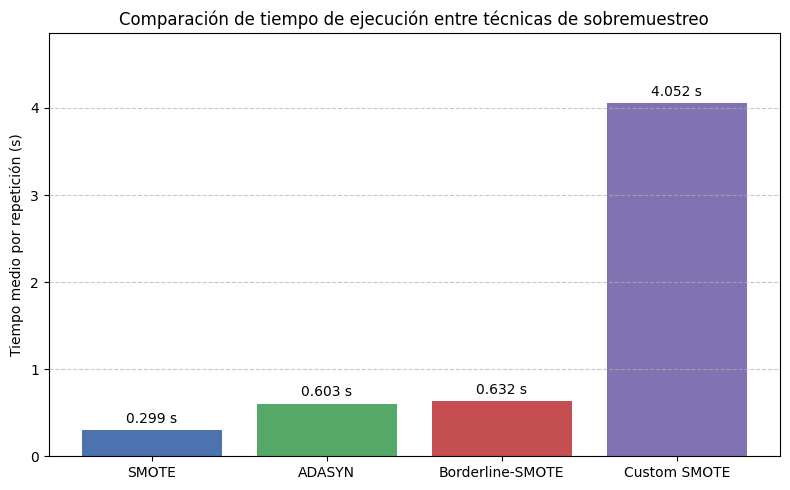

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

mean_times = {
    "SMOTE": time_smote,
    "ADASYN": time_adasyn,
    "Borderline-SMOTE": time_borderline,
    "Custom SMOTE": time_custom
}

# Obtener métodos y tiempos en segundos
methods = list(mean_times.keys())
times_s = list(mean_times.values())

# Crear gráfico
plt.figure(figsize=(8,5))
bars = plt.bar(methods, times_s, color=['#4C72B0', '#55A868', '#C44E52', '#8172B3'])

# Etiquetas sobre cada barra
for bar, t in zip(bars, times_s):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,  # margen en segundos
             f'{t:.3f} s', ha='center', va='bottom', fontsize=10)

plt.ylabel("Tiempo medio por repetición (s)")
plt.title("Comparación de tiempo de ejecución entre técnicas de sobremuestreo")
plt.ylim(0, max(times_s)*1.2)  # Deja espacio para las etiquetas
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
